# Amplitude embedding (simulator)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data into qubits using amplitude embedding (non-conventional domain)
* measure qubits on simulator --> expected outcomes (back to conventional domain)
* apply 2D IFT --> fidelity computation

Amplitude embedding:

* from https://docs.pennylane.ai/en/stable/code/api/pennylane.AmplitudeEmbedding.html
* literature: https://hillside.net/plop/2020/papers/weigold.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

### Prerequisites

In [2]:
# create a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: # image center
        center = (int(w/2), int(h/2))
    if radius is None: # smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask

## 1) Generating an artificial image of the sky (frequency domain)

In [3]:
# image of the sky filled with double precision complex floats (32 bits per real/imaginary parts)
# pixels are set to low complex random values (image background/noise) 
# few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 4
image = np.zeros((n, n), dtype='complex64')
image.real = np.random.randn(n , n)/10
image.imag = np.random.randn(n , n)/100

h, w = image.shape
mask = circular_mask(h, w, radius=h/3)
sky_image = image.copy()
sky_image[mask] = complex(np.random.rand()*10, np.random.rand()*10)
print(sky_image)

[[ 4.05629463e-02+4.2208689e-03j  1.66007146e-01-1.0848098e-02j
   3.39801278e-04-4.0660915e-03j  9.08517092e-02+4.3605953e-03j]
 [-1.72526553e-01-1.2145733e-02j -7.84443617e-02-1.1615011e-02j
   5.48627234e+00+7.9550171e+00j  1.24229625e-01+4.7031720e-03j]
 [-1.81060787e-02-2.1971774e-03j  5.48627234e+00+7.9550171e+00j
   5.48627234e+00+7.9550171e+00j  5.48627234e+00+7.9550171e+00j]
 [-2.23406348e-02-1.9200917e-02j  8.35202113e-02-5.4782182e-03j
   5.48627234e+00+7.9550171e+00j  1.02418058e-01-1.2088304e-02j]]


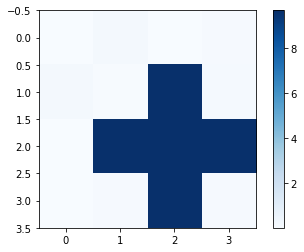

In [4]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [5]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 27.747873 +39.71073j   -16.656485 -23.743893j    4.825619  +7.952594j
  -16.60665  -24.036724j ]
 [-16.12524  -23.578848j    5.7202244 +8.06346j     5.284823  +7.9738894j
    5.383089  +8.167914j ]
 [  5.7290716 +8.002313j    5.697756  +7.6957264j -16.266289 -23.853739j
    5.7087574 +8.289181j ]
 [-16.16066  -24.159525j    5.3385615 +7.7172318j   5.2920218 +7.9538236j
    5.7365313 +7.913399j ]]


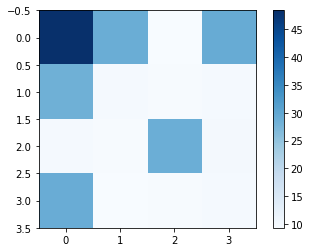

In [6]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

### Sanity check

In [7]:
img = np.fft.ifft2(visibilities).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()
 
print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 7.0395396e-15
Imaginaries MSE: 1.0461606e-14


## 3) Data encoding: amplitude embedding (non-conventional domain)

In [8]:
# Amplitude embedding encodes a normalized 2^n-dimensional feature vector into the state of n qubits
# --> uses log2(n) qubits for n classical data

n = visibilities.shape[0]*visibilities.shape[1]
data = visibilities.flatten()

#normalization to prepare a qstate with measurement probabilites summing up to 1 (SUM (amplitudes²) = 1)
norm = qml.math.sum(qml.math.abs(data) ** 2)
normalized_data = data / qml.math.sqrt(norm)

wires = range(int(math.log2(n))) # set the number of qubits (no padding needed if outputs an integer=integer.0)
amp_dev = qml.device('default.qubit', wires)

# encoding
@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires) # normalize = True
    return qml.state() #qml.expval(qml.PauliZ(wires=wires))

readout = amp_encoding(normalized_data).astype('complex64')
readout = readout*qml.math.sqrt(norm) # denormalization of the measurements outcomes
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])
print(readout)

[[ 27.747873 +39.71073j   -16.656485 -23.743893j    4.825619  +7.952594j
  -16.60665  -24.036724j ]
 [-16.12524  -23.578848j    5.7202244 +8.06346j     5.284823  +7.9738894j
    5.383089  +8.167914j ]
 [  5.7290716 +8.002313j    5.697756  +7.6957264j -16.266289 -23.853739j
    5.7087574 +8.289181j ]
 [-16.16066  -24.159525j    5.3385615 +7.7172318j   5.2920218 +7.9538236j
    5.7365313 +7.913399j ]]


## 4) Applying 2D IFT (fidelity test)

In [9]:
img = np.fft.ifft2(readout).astype('complex64')

test_real = ((sky_image.real - img.real)**2).mean()
test_imag = ((sky_image.imag - img.imag)**2).mean()

print('Reals MSE: '+ str(test_real))
print('Imaginaries MSE: '+ str(test_imag))

Reals MSE: 7.0395396e-15
Imaginaries MSE: 1.0461606e-14


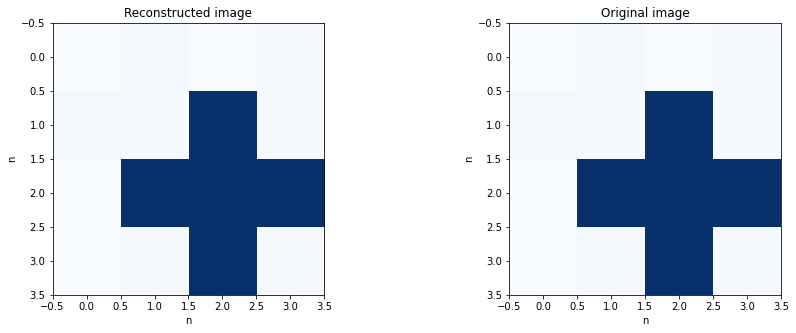

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(img)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Blues')
axs[1].imshow(modulus2, cmap='Blues')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')